online version of this notebook : https://colab.research.google.com/drive/12iz5_mTOmTa0oyn5IZZYnEskVUonViVW#scrollTo=VSTgsilO1_ur

In [1]:
import tensorflow as tf
import keras
from keras.optimizers import Adam
from keras.layers import Dense
from keras.models import Model, Sequential
from keras.activations import relu, softmax
from keras.losses import SparseCategoricalCrossentropy


import numpy as np
from matplotlib import pyplot as plt

## PARAMS
<a name="params">.</a>
<a href="#datasyn">go to data gen</a>

In [2]:
# Model parameters

k = 4
NUM_CHANNEL_USES = 7
block_size = 320

snr = 6 #9 for training

model_training_num_of_frames = 10**3 #10**4
model_validating_num_of_frames = 10**2 #10**3

n_train = block_size * model_training_num_of_frames
n_val   = block_size * model_validating_num_of_frames

# Geanerating dataset
model_output_num_of_frames = 10**5
n_out = block_size * model_output_num_of_frames

num_epoches = 5

In [3]:
SLICED_Y_LENGTH = 16
BATCH_SIZE =  1

# in teh feature extractor path "f" : design param
# Our experiments have shown that even a
# small number of features, e.g., F = 4, significantly improves
# the performance.
N_FEATURES_EXTRACTED = 8

In [4]:
def R2C(a):

    aa = tf.cast(tf.reshape(a,shape=(BATCH_SIZE,-1,2)),tf.float32)

    aaa = tf.complex(aa[:,:,0],aa[:,:,1])
    return aaa

def C2R(a):
    real, imag = tf.expand_dims(tf.math.real(a),axis=2) ,tf.expand_dims(tf.math.imag(a), axis=2)
    R = tf.concat((real,imag),axis=2)
    R = tf.reshape(R , (BATCH_SIZE,-1)  )
    return R


# Stochastic Channel Model & Layer

### Additional Layers

In [5]:
class L2Normalization(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(L2Normalization, self).__init__(**kwargs)
    def call(self, inputs):
        out = tf.nn.l2_normalize(inputs, axis=-1)
        print("normalize output shape = ",out.shape)
        return out
    def get_config(self):
        return super(L2Normalization, self).get_config()


def generate_nakagami_samples(m, omega):
    nakagami_amp_vec = nakagami.rvs(m,omega,size =  NUM_CHANNEL_USES)   # Same gain for the real part and the imaginary part
    nakagami_phase_vec = np.random.uniform(low=0.0, high=2*np.pi, size = NUM_CHANNEL_USES)    # phase shift will effect the complex number
    nakagami_for_real = np.reshape(nakagami_amp_vec*np.cos(nakagami_phase_vec),(-1,1))
    nakagami_for_imag = np.reshape(nakagami_amp_vec*np.sin(nakagami_phase_vec),(-1,1))
    fading_vec = np.reshape(np.concatenate((nakagami_for_real,nakagami_for_imag),axis=1),(1,-1))[0]
    return  tf.constant(fading_vec, dtype=tf.float32)

class NakagamiNoiseLayer(tf.keras.layers.Layer):
    def __init__(self, distribution_params, **kwargs):
        super(NakagamiNoiseLayer, self).__init__(**kwargs)
        self.distribution_params = distribution_params

    def call(self, inputs, training=False):
      fading = generate_nakagami_samples(m = self.distribution_params["m"],
                                        omega = self.distribution_params["omega"])
      return inputs * fading

### Stochastic channel

In [6]:
from scipy.stats import truncnorm
from scipy.stats import uniform

channel_parameters = {
    "r"        : 4,             # For upsampling -> number of complex samples per symbol
    "roll_off" : 0.35,          # Roll off factor
    "num_taps" : 31,            # L -> Number of taps (odd) for RRC filter
    "f_s"      : 25e4,          # Add what is in the physical implementation
    "T_bound"  : 1/25e4,        # 1/f_s Go through the resharch paper Deep Learning Based Communication Over the Air  (content under table 1)
    "time_delay" : np.random.uniform(-1,1), # To convert the time delay into discrete domain, time dilay is giving relative to the sampling period
    "CFO"      : 5e3,           # Observe from the physical implementation
    "CFO_std"  : 5e3/25e4,      # CFO/f_s
    "snr"      : 6,             # noise power will be calculating assuming transmittting power of 1
    "phase_off": uniform.rvs(scale = 2*np.pi)  # constant for one channel input
}

In [7]:

# Making the stochasticChannelLayer

# function to create the complex values
def real_to_complex_tensor(inp_tensor):
  inp_tensor = tf.reshape(inp_tensor, [-1, 2])
  real_part = inp_tensor[:, 0]
  imag_part = inp_tensor[:, 1]
  complex_tensor = tf.complex(real_part, imag_part)
  return complex_tensor

def complex_to_real_tensor(inp_tensor):
   real_part , imag_part = tf.math.real(inp_tensor), tf.math.imag(inp_tensor)
   real_part = tf.reshape(real_part,[-1,1])
   imag_part = tf.reshape(imag_part,[-1,1])
   return tf.reshape(tf.concat([real_part,imag_part],1),[-1])

# Upsample
def upsampling(inp,r):
  com_reshape = tf.reshape(inp,[-1,1])
  padding = tf.constant([[0,0],[0,r-1]])
  upsampled = tf.pad(com_reshape,padding,"CONSTANT")
  return tf.reshape(upsampled,[-1])

# Normalized RRC with time shift
def NRRC_filter(num_taps, roll_off, time_delay):
  t = np.linspace(-(num_taps-1)/2,(num_taps-1)/2,num_taps) - time_delay
  eps = np.finfo(float).eps # Small epsilon to avoid divisiomn by zero
  pi = np.pi
  def RRC_filter_coff(t):
    if abs(t) < eps:  # For t==0
      return 1.0 - roll_off + (4*roll_off/pi)
    elif roll_off != 0 and (abs(t-1/(4*roll_off))<eps or abs(t+1/(4*roll_off))<eps):
      return (roll_off/np.sqrt(2))*(1 + 2/pi)*np.sin(pi/(4*roll_off)) + (1- 2/pi)*np.cos(pi/(4*roll_off))
    else:
      nu = np.sin(pi*t*(1-roll_off)) + 4*roll_off*t*np.cos(pi*t*(1+roll_off))
      den = pi*t*(1-(4*roll_off*t)**2)
      return nu/(den + eps)
  filter_coff = np.array([RRC_filter_coff(T) for T in t])
  NRRC_filter_coff = filter_coff / np.sum(np.abs(filter_coff))
  print(f"Time_delay = {time_delay}")
  plt.stem(t,NRRC_filter_coff)  # Plot for visualization
  return tf.constant(NRRC_filter_coff,dtype = tf.float32)

# Phase offset
def PhaseOffset_vec(batch_size,NUM_CHANNEL_USES,num_taps,r,CFO_std,phase_off):
  l = batch_size*r*NUM_CHANNEL_USES+num_taps-1
  CFO_off = 0.1*CFO_std# truncnorm.rvs(-1.96,1.96)*CFO_std  # boundaries will be selected for 95% confidence
  print("CFO_off =",CFO_off)
  print("Phase offset = ",phase_off)                                          # CFO_min and CFO_max (boundaries) will be selected for 95% confidence
  exp_vec = []
  for i in range(l):
    exp_vec.append(tf.math.exp(tf.constant([0+(2*np.pi*i*CFO_off+phase_off)*1j],dtype=tf.complex64)))
  return tf.reshape(tf.stack(exp_vec),[-1])


class UpsamplingLayer(keras.layers.Layer):
    def __init__(self, r =channel_parameters["r"]):
        super().__init__()
        self.r = r
    def call(self,inputs):
       return upsampling(inputs,self.r)

class PulseShaping(keras.layers.Layer):
    def __init__(self,num_taps,roll_off,time_delay):
      super().__init__()
      self.nrrc_filter = NRRC_filter(num_taps,roll_off,time_delay)
      self.nrrc_filter = tf.reshape(self.nrrc_filter,[num_taps,1,1])
      self.num_taps = num_taps
    def call(self, inputs):
      padding_size = self.num_taps // 2
      paddings = tf.constant([[padding_size, padding_size]])
      real_part = tf.pad(tf.math.real(inputs), paddings, "CONSTANT")
      imag_part = tf.pad(tf.math.imag(inputs), paddings, "CONSTANT")
      real_part = tf.reshape(real_part,[1,-1,1])
      imag_part = tf.reshape(imag_part,[1,-1,1])
      real_conv = tf.nn.conv1d(real_part,self.nrrc_filter,stride=1,padding="SAME")
      imag_conv = tf.nn.conv1d(imag_part,self.nrrc_filter,stride=1,padding="SAME")
      real_conv = tf.reshape(real_conv,[-1])
      imag_conv = tf.reshape(imag_conv,[-1])
      return tf.complex(real_conv,imag_conv)

class PhaseOffset(keras.layers.Layer):
    def __init__(self,batch_size,NUM_CHANNEL_USES,num_taps,r,CFO_std,phase_off):
      super().__init__()
      self.batch_size = batch_size
      self.num_channel_uses = NUM_CHANNEL_USES
      self.num_taps = num_taps
      self.r = r
      self.CFO_std = CFO_std
      self.phase_off = phase_off
    def call(self,inputs):
       return inputs * PhaseOffset_vec(self.batch_size, self.num_channel_uses,self.num_taps,self.r,self.CFO_std, self.phase_off)

class StochasticChannelLayer(keras.layers.Layer):
    """This channel will output 1D tensor.
        channel_parameters ---> custom class for parameters store
                                channel_parameters = {
                                    "r"        : 4,             # For upsampling -> number of complex samples per symbol
                                    "roll_off" : 0.35,          # Roll off factor
                                    "num_taps" : 31,            # L -> Number of taps (odd) for RRC filter
                                    "f_s"      : 25e4,          # Add what is in the physical implementation
                                    "T_bound"  : 1/25e4,        # 1/f_s Go through the resharch paper Deep Learning Based Communication Over the Air  (content under table 1)
                                    "time_delay" : np.random.uniform(-1,1), # To convert the time delay into discrete domain, time dilay is giving relative to the sampling period
                                    "CFO"      : 5e3,           # Observe from the physical implementation
                                    "CFO_std"  : 5e3/25e4,      # CFO/f_s
                                    "snr"      : 6,             # noise power will be calculating assuming transmittting power of 1
                                    "phase_off": uniform.rvs(scale = 2*np.pi)  # constant for one channel input
                                }
        r ----------> upsampling constant (number of complex samples per symbol)
        time_delay -> uniformly distributed time delay between (-1,1), discrete domain,
                      time dilay is giving relative to the sampling period
        CFO_std ----> CFO_frequency / sampling_frequency is taken as the standared deviation
        snr --------> snr for AWGN channel
        output_shape -> None - output_shape is 1D tensor for sequence decoder, or give an output shape prefer """
    def __init__(self, NUM_CHANNEL_USES,batch_size,channel_parameters):
        super().__init__()
        self.UpSamplingLayer_inst = UpsamplingLayer(channel_parameters["r"])
        self.PulseShaping_inst = PulseShaping(channel_parameters['num_taps'],channel_parameters['roll_off'],channel_parameters['time_delay'])
        self.PhaseOffset_inst = PhaseOffset(batch_size,NUM_CHANNEL_USES,channel_parameters['num_taps'],channel_parameters['r'],channel_parameters['CFO_std'],channel_parameters['phase_off'])
        self.AWGNlayer = keras.layers.GaussianNoise(stddev = np.sqrt(1/10**(channel_parameters['snr']/10)))
    def call(self, inputs):
      inputs = tf.reshape(inputs,[-1])
      inputs = real_to_complex_tensor(inputs)
      x = self.UpSamplingLayer_inst(inputs)
      x = self.PulseShaping_inst(x)
      x = self.PhaseOffset_inst(x)
      x = complex_to_real_tensor(x)
      x = self.AWGNlayer(x)
      #print("StochasticChannelLayer output shape = ",x.shape)
      return x


# Stochastic channel model
class StochasticChannelModel(keras.Model):
    """This channel will output 1D tensor.
        channel_parameters ---> custom class for parameters store
                                channel_parameters = {
                                    "r"        : 4,             # For upsampling -> number of complex samples per symbol
                                    "roll_off" : 0.35,          # Roll off factor
                                    "num_taps" : 31,            # L -> Number of taps (odd) for RRC filter
                                    "f_s"      : 25e4,          # Add what is in the physical implementation
                                    "T_bound"  : 1/25e4,        # 1/f_s Go through the resharch paper Deep Learning Based Communication Over the Air  (content under table 1)
                                    "time_delay" : np.random.uniform(-1,1), # To convert the time delay into discrete domain, time dilay is giving relative to the sampling period
                                    "CFO"      : 5e3,           # Observe from the physical implementation
                                    "CFO_std"  : 5e3/25e4,      # CFO/f_s
                                    "snr"      : 6,             # noise power will be calculating assuming transmittting power of 1
                                    "phase_off": uniform.rvs(scale = 2*np.pi)  # constant for one channel input
                                }
        r ----------> upsampling constant (number of complex samples per symbol)
        time_delay -> uniformly distributed time delay between (-1,1), discrete domain,
                      time dilay is giving relative to the sampling period
        CFO_std ----> CFO_frequency / sampling_frequency is taken as the standared deviation
        snr --------> snr for AWGN channel
        output_shape -> None - output_shape is 1D tensor for sequence decoder, or give an output shape prefer """
    def __init__(self, NUM_CHANNEL_USES,batch_size,channel_parameters):
        super().__init__()
        self.UpSamplingLayer_inst = UpsamplingLayer(channel_parameters['r'])
        self.PulseShaping_inst = PulseShaping(channel_parameters['num_taps'],channel_parameters['roll_off'],channel_parameters['time_delay'])
        self.PhaseOffset_inst = PhaseOffset(batch_size,NUM_CHANNEL_USES,channel_parameters['num_taps'],channel_parameters['r'],channel_parameters['CFO_std'],channel_parameters['phase_off'])
        self.AWGNlayer = keras.layers.GaussianNoise(stddev = np.sqrt(1/10**(channel_parameters['snr']/10)))
    def call(self, inputs):
      inputs = tf.reshape(inputs,[-1])
      inputs = real_to_complex_tensor(inputs)
      x = self.UpSamplingLayer_inst(inputs)
      x = self.PulseShaping_inst(x)
      x = self.PhaseOffset_inst(x)
      x = complex_to_real_tensor(x)
      x = self.AWGNlayer(x)
      #print("StochasticChannelLayer output shape = ",x.shape)
      return x


In [8]:
# Decoder mask layer

class PulseShaping_Dec(keras.layers.Layer):
    def __init__(self,num_taps,r,roll_off,time_delay):
      super().__init__()
      self.nrrc_filter = NRRC_filter(num_taps,roll_off,time_delay)
      self.nrrc_filter = tf.reshape(self.nrrc_filter,[num_taps,1,1])
      self.num_taps = num_taps
      self.r =r
    def call(self, inputs):
      inputs = tf.reshape(inputs,[1,-1,1])
      inp_conv = tf.nn.conv1d(inputs,self.nrrc_filter,stride=self.r,padding="VALID")
      inp_conv = tf.reshape(inp_conv,[-1])
      return inp_conv


class DecoderMaskLayer(keras.layers.Layer):
    def __init__(self,channel_parameters,NUM_CHANNEL_USES):
        super().__init__()
        # self.Convo = PulseShaping_Dec(channel_parameters['num_taps'],channel_parameters['r'],channel_parameters['roll_off'],channel_parameters['time_delay'])
        self.Convo = tf.keras.layers.Conv1D(1,channel_parameters['num_taps'],strides=channel_parameters['r'], padding = 'valid',activation = 'relu',use_bias=True)
        self.channel_uses = NUM_CHANNEL_USES
    def call(self,inputs):
        inp = tf.reshape(inputs,[-1,2])
        real_part, imag_part = inp[:,0],inp[:,1]
        vec_shape = real_part.shape[0]
        #print("real shape",real_part.shape)
        real_part, imag_part = tf.reshape(real_part,[1,vec_shape,1]), tf.reshape(imag_part,[1,vec_shape,1])
        real_part = tf.reshape(self.Convo(real_part),[-1,1])
        imag_part = tf.reshape(self.Convo(imag_part),[-1,1])
        #print("real shape after conv ",real_part.shape)
        outputs = tf.concat([real_part,imag_part],1)
        return tf.reshape(outputs,[-1,2*self.channel_uses])

## Main Blocks in the Sequence Decoder

In [23]:

class FeatureExtractor(Model):
    def __init__(self):
        super().__init__()

        self.cf1 = Dense(256,name="r3->FeatureExtractor->cf1")

        self.cf2 = Dense(N_FEATURES_EXTRACTED,name="r3->FeatureExtractor->cf2")

        self.cf_state = Dense(8,name="featureExtractor_stateFC")

    def call(self,sliced_y,prev_state_FE):
       

        # combine the sliced_y and prev_state_FE
        sliced_y = tf.concat([sliced_y,prev_state_FE],axis=1)

        sliced_y = self.cf1(sliced_y)
        sliced_y = relu(sliced_y)

        state_FE = self.cf_state(sliced_y) # state calculated here

        sliced_y = self.cf2(state_FE)

        return sliced_y,state_FE

class PhaseEstimator(Model):
    def __init__(self):
        super().__init__()

        self.cf1 = Dense(256,name="r3->PhaseEstimator->cf1")
        self.cf2 = Dense(2,name="r3->PhaseEstimator->cf2")

        self.cf_state = Dense(8,name="PhaseEstimator_stateFC")


    def call(self,sliced_y,prev_state_PE):
        # combine sliced_y and prev_state_PE
        sliced_y = tf.concat([sliced_y,prev_state_PE],axis=1)
        sliced_y = self.cf1(sliced_y)
        sliced_y = relu(sliced_y)

        state_PE = self.cf_state(sliced_y) # state calculated here

        sliced_y = self.cf2(state_PE)

        return sliced_y,state_PE


class Rx_Decoder_old(Model):
    def __init__(self):
        super().__init__()

        self.cf1 = Dense(256)
        self.cf2 = Dense(256)
        self.cf3 = Dense(16)

    def call(self,concat):

        concat = self.cf1(concat)
        concat = relu(concat)
        concat = self.cf2(concat)
        concat = relu(concat)

        concat = self.cf3(concat)

        # do not use softmax here : put from logit  = True in loss func
        # concat = softmax(concat)

        return concat


class Rx_Decoder_new(Model):
    def __init__(self):
        super().__init__()

        self.cf1 = Dense(256,name="r3->Rx_Decoder_new->cf1")
        self.cf2 = Dense(256,name="r3->Rx_Decoder_new->cf2")
        self.cf3 = Dense(16,name="final_out_cf3")

        # useless
        #self.cf4_state = Dense(8,name="state_dense_cf4")

    def call(self,concat):

        concat = self.cf1(concat)
        concat = relu(concat)
        concat = self.cf2(concat)
        concat = relu(concat)

        # state = self.cf4_state(concat)
        concat = self.cf3(concat)



        # do not use softmax here : put from logit  = True in loss func
        # concat = softmax(concat)

        return concat




class InternalSlicer(Model):
    def __init__(self,l1,l2,complex_length):
        super().__init__()

        # define the slice boundaries
        mid = complex_length // 2
        self.start = mid - l1
        self.end = mid + l2 + 1

    def call(self,sliced_y):
        
        print("r3 : sliced_y.shape",sliced_y.shape)

        ret = C2R(R2C(sliced_y)[:, self.start:self.end])

        return ret


def phase_multiply(internally_sliced_y,estimated_phase):
    # (a,b) * (c,d) = (ac-bd,ad+bc)

    internally_sliced_y_complex = R2C(internally_sliced_y)
    estimated_phase_complex = R2C(estimated_phase)
    phase_corrected_complex = estimated_phase_complex * internally_sliced_y_complex

    phase_corrected = C2R(phase_corrected_complex)
    return phase_corrected






## Fake data syn

In [24]:
# generate fake data

# m = 512* 2** 2
# X = tf.random.normal(shape=(block_size,SLICED_Y_LENGTH),
#                      mean=0,
#                      stddev=1)

# Y = tf.random.uniform(shape=(m,1),
#                       minval=0,
#                       maxval=16,
#                       dtype=tf.int32)
# Y = keras.utils.to_categorical(Y,16)


## Main Model : Sequence Decoder Class

In [25]:
# sequence decoder


class SequenceDecoder(Model):

    def __init__(self,take_prev_phase_state=False):
        super(SequenceDecoder,self).__init__()

        self.take_prev_phase_state = take_prev_phase_state

        self.feature_extractor = FeatureExtractor()
        self.phase_estimator = PhaseEstimator()
        self.internal_slicer = InternalSlicer(l1=4,l2=4,complex_length=SLICED_Y_LENGTH//2)

        if take_prev_phase_state:
            self.rx_decoder_RNN = Rx_Decoder_new()
        else:
            raise Exception("How here come??")
            #self.rx_decoder = Rx_Decoder_old()



    def call(self,sliced_y,prev_state_FE=None,prev_state_PE=None):

        if prev_state_PE is None:
            print(" How this none?")
            prev_state_PE = tf.constant(tf.zeros((block_size,8)))
        if prev_state_FE is None:
            print(" How this none?")
            prev_state_FE = tf.constant(tf.zeros((block_size,8)))


        # RNN conn starts here

        output_FE = self.feature_extractor(sliced_y,prev_state_FE=prev_state_FE)
        extracted_features,state_FE = output_FE[0], output_FE[1]



        output_PE = self.phase_estimator(sliced_y,prev_state_PE=prev_state_PE)
        estimated_phase,state_PE = output_PE[0], output_PE[1]

        # RNN conn ends here

        internally_sliced_y = self.internal_slicer(sliced_y)



        phase_corrected_ = phase_multiply(internally_sliced_y,estimated_phase)

        concat = tf.concat((extracted_features,phase_corrected_),axis=1)
        if self.take_prev_phase_state:
            st_hat = self.rx_decoder_RNN(concat)
            return (st_hat,state_FE,state_PE)
        else:
            raise Exception("How came here????")
            print("--PROBLEM--")
            st_hat = self.rx_decoder(concat)
            return st_hat



    def custom_train(self,X,Y,epochs=1): # X =  vertically stacked sliced_y, y = message index

        # tarin per each time step
        for _ in range(epochs):

            # temp_prev_state_PE = [tf.constant(tf.zeros((X.shape[0],8)))] #append the last PE state here
            # temp_prev_state_FE = [tf.constant(tf.zeros((X.shape[0],8)))] #append the last FE state here

            temp_prev_state_PE = tf.constant(tf.zeros((1,8)))
            temp_prev_state_FE = tf.constant(tf.zeros((1,8)))

            loss_acc = 0

            for i in range(X.shape[0]):
                print(f"iterration : {i}")
                x =  tf.expand_dims(X[i,:],axis=0)

                y = tf.expand_dims(Y[i,:],axis=0)

                with tf.GradientTape() as tape:
                    output = self.call(x,
                                       prev_state_PE=temp_prev_state_PE,
                                       prev_state_FE=temp_prev_state_FE)

                    st_hat,state_FE,state_PE = output[0], output[1], output[2]
                    loss = self.compiled_loss(y,st_hat)

                    #temp_prev_state = state ###### assign add dala balanna

                    temp_prev_state_FE = (state_FE)
                    temp_prev_state_PE = (state_PE)

                grads = tape.gradient(loss,self.trainable_variables)
                self.optimizer.apply_gradients(zip(grads,self.trainable_variables))

                loss_acc += loss.numpy() / X.shape[0] # take the mean
                print("loss (individual): ", loss.numpy())
            print(f'Epoch  : {_}/{epochs} --> Loss = {loss_acc}')

        # returning the final batch's loss
        return loss_acc




In [26]:
# test the SD
# tested and worked
# mySD =   SequenceDecoder(take_prev_phase_state=True)

# mySD.compile(optimizer=Adam(learning_rate=1e-2),
#              loss=SparseCategoricalCrossentropy(from_logits=True),
#              metrics=['accuracy'])


# mySD.custom_train(X,Y)





In [27]:
# mySD.build((2048,16))

# Autoencoder model

In [28]:
AWGN_std = np.sqrt(1/10**(snr/10))
act_func = 'tanh' # 'relu'


In [29]:
# # Encoder
# Encoder = Sequential([
#                     Dense(2**k, activation=act_func,input_shape=(2**k,)),#Dense(2**k, activation=act_func,input_shape=(k,)),
#                     Dense(2**k, activation=act_func),
#                     Dense(2*NUM_CHANNEL_USES, activation='linear',name="Encode_last_dense"),
#                     L2Normalization(name="normalization_layer"),
# ])

# # Channel
# Stochastic_channel = StochasticChannelModel(NUM_CHANNEL_USES,block_size,r,roll_off,L,time_delay,CFO_std,snr)

# # Sequence decoder
# Seq_decoder = SequenceDecoder(take_prev_phase_state=True)

# # Auto encoder
# Autoencoder = Sequential([
#     Encoder,
#     Stochastic_channel,
#     # Seq_decoder
# ])

In [30]:
# Autoencoder.compile(optimizer=Adam(learning_rate=1e-2),
#                     loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))


# # cxannot connect the RNN for a whoe batch

# # history = Autoencoder.fit(x_train,
# #                           y_train,
# #                           batch_size=block_size,
# #                           epochs=num_epoches,
# #                           verbose=2,
# #                           validation_data=(x_val,y_val))

# train_history = Autoencoder.custom_train(x_train,y_train,epochs=1)
# print("train_history", train_history)


# def calc_block_accuracy(preds,y_val):
#     n_bits_per_block = preds.shape[1]
#     n_correct_bits = np.sum(preds == y_val,axis=1)
#     block_accuracy = np.mean(n_correct_bits == n_bits_per_block)
#     return block_accuracy

# preds = AE.predict(x_val,batch_size=block_size)>0.5
# accuracy =  calc_block_accuracy(preds,y_val)
# print(f"validation accuracy = {accuracy}")
# print(f"snr = {snr}")

<a href="#params">go toparams</a><br/>

<a name="datasyn">Generate Data</a>

In [31]:
# synthesize some data
x_train = tf.cast(tf.random.uniform((block_size,),minval=0,maxval=2**k),
                  (tf.int32))

y_train = tf.expand_dims(x_train,axis=1)

x_train =  tf.one_hot(x_train,depth=2**k)



In [32]:
print("x_train.shape: ",x_train.shape)
print("y_train.shape: ",y_train.shape)

x_train.shape:  (320, 16)
y_train.shape:  (320, 1)


In [33]:
# @tf.function
def ExternalSlicer(input_vec,padding=30,gamma=4):
    '''
    input_vec: should be the real and imag parts separately.
    padding  : how much the window should expand per each side
    '''
    assert len(input_vec.shape) == 1, "Need 1D vector. Cannot process multiple frames at once"
    assert (input_vec.shape[0]-2*padding ) / (2 * NUM_CHANNEL_USES * gamma) == block_size
    
    output_array = []
    
    for i in range(block_size):
        window_size = (2 * NUM_CHANNEL_USES * gamma)
        start = window_size * i
        end = start + window_size + padding * 2
        output_array.append(input_vec[start:end])
    
    return tf.stack(output_array)

In [36]:
class End2EndSys(Model):
    
    def __init__(self):
        super(End2EndSys,self).__init__()
        
        self.encoder = Sequential([
            
                    Dense(2**k, activation=act_func,input_shape=(None,2**k,),name="e2es->encoder->cf1"),#Dense(2**k, activation=act_func,input_shape=(k,)),
                    Dense(2**k, activation=act_func,name="e2es->encoder->cf2"),
                    Dense(2*NUM_CHANNEL_USES, activation='linear',name="Encode_last_dense"),
                    L2Normalization(name="normalization_layer"),
            
                    ])

        # Channel
        self.stochastic_channel = StochasticChannelModel(NUM_CHANNEL_USES,block_size,channel_parameters)

        # conv layer to mimim the external slicer
        padding=30
        gamma=4
        window_size = (2 * NUM_CHANNEL_USES * gamma)
        taps = 0 + window_size + padding * 2
        
        self.conv1 = tf.keras.layers.Conv1D(window_size,
                                            taps, #channel_parameters['num_taps']+30,
                                            strides=window_size, 
                                            padding = 'valid',
                                            activation = 'linear',
                                            use_bias=True)
       
        # Sequence decoder
        self.seq_decoder = SequenceDecoder(take_prev_phase_state=True)
    
    
    def call(self,x):
        
        encodings = self.encoder(x)
        
        all_y = self.stochastic_channel(encodings)
        print("all_y.shape", all_y.shape)
        
        all_y  = tf.reshape(all_y,(1,-1,1))
        slices = self.conv1(all_y)
        slices = tf.reshape(slices, (-1,1))
        
        print("slices.shape", slices.shape)
#         return 
        
#         slices = ExternalSlicer(all_y,)
        st_hat_array = []
        
        temp_prev_state_PE = tf.constant(tf.zeros((1,8)))
        temp_prev_state_FE = tf.constant(tf.zeros((1,8)))

        # take one slice only --- for testing
        for i in range(slices.shape[0]):
            test_slice = tf.expand_dims(slices[i,:],axis=0)

            
            output = self.seq_decoder(test_slice,temp_prev_state_FE,temp_prev_state_PE)
            # update states as well
            st_hat,temp_prev_state_FE,temp_prev_state_PE = output[0], output[1], output[2]
        
            st_hat_array.append(st_hat[0])
        
        return tf.stack(st_hat_array)
        
#     @tf.function

    def custom_fit(self,x,y,epochs=1):

        for _ in range(epochs):
            
            loss_acc = 0.
            
            temp_prev_state_PE = tf.constant(tf.zeros((1,8)))
            temp_prev_state_FE = tf.constant(tf.zeros((1,8)))
            
            with tf.GradientTape(persistent=False) as tape:
                
                encodings = self.encoder(x,
                                         training=True)
                print("r3 1")

                all_y = tf.expand_dims(self.stochastic_channel(encodings),axis=1)
                
                print("r3 2")
                print("all_y.shape", all_y.shape)
                
                
#                 slices = ExternalSlicer(all_y,)
                slices = self.conv1(all_y)
                print("r3 3")
    #             st_hat_array = []

    
                for i in range(slices.shape[0]):
                    print("iteration" , i)
                    test_slice = tf.expand_dims(slices[i,:],axis=0)
                    corr_label = tf.expand_dims(y[i,:],axis=0)


                    output = self.seq_decoder(test_slice,temp_prev_state_FE,temp_prev_state_PE)
                    # update states as well
                    st_hat,state_FE,state_PE = output[0], output[1], output[2]
                    loss = self.compiled_loss(corr_label,st_hat)

    #                 st_hat_array.append(st_hat[0])
                    with tape.stop_recording():
                        grads = tape.gradient(loss,self.trainable_variables)
                        self.optimizer.apply_gradients(zip(grads,self.trainable_variables))

                    temp_prev_state_FE = state_FE
                    temp_prev_state_PE = state_PE
                    
#                     print(type(loss.numpy()))
                    loss_acc += loss.numpy() / slices.shape[0]

                print(f'Epoch  : {_}/{epochs} --> Loss = {loss_acc}')

    
        
        return loss_acc
        
        
        
        
        
        
        

normalize output shape =  (None, None, 14)
Time_delay = -0.7730157637550279
normalize output shape =  (320, 14)
CFO_off = 0.002
Phase offset =  1.8662559008321036
all_y.shape (17980,)
slices.shape (17920, 1)
r3 : sliced_y.shape (1, 1)


InvalidArgumentError: Exception encountered when calling layer "internal_slicer_2" (type InternalSlicer).

Input to reshape is a tensor with 1 values, but the requested shape requires a multiple of 2 [Op:Reshape]

Call arguments received by layer "internal_slicer_2" (type InternalSlicer):
  • sliced_y=tf.Tensor(shape=(1, 1), dtype=float32)

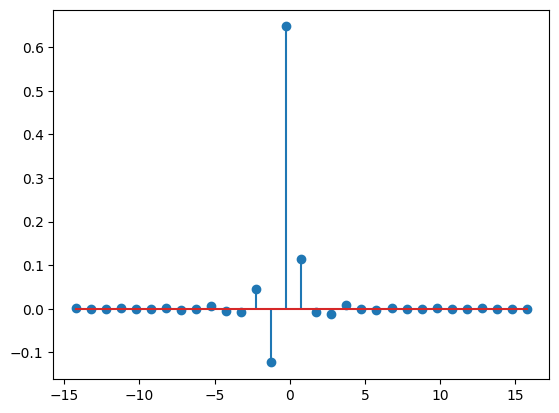

In [37]:
end2end = End2EndSys()
end2end(x_train).shape

In [ ]:

end2end = End2EndSys()
# end2end(x_train).shape

end2end.compile(optimizer=Adam(learning_rate=1e-2),
               loss=SparseCategoricalCrossentropy(from_logits=True))


end2end.custom_fit(x_train,y_train,epochs=1)

In [ ]:
17980/320,17980%320


In [ ]:
Encoder(x_train).shape

In [ ]:
(2*28+30) * 2

In [ ]:
(17980-60)/(28*2)

In [ ]:
ExternalSlicer(out)